In [2]:
import sys
sys.path.append('..')

from EBC import EBC

In [3]:
import mdtraj as md
import numpy as np

import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from openff.toolkit.topology import Molecule

In [4]:
N = 1000
OFFSET = 0
TEMPERATURE = 2000

In [5]:
SYSTEM_NAME = 'isoleucine'
SMILE = "CC[C@H](C)[C@@H](C(=O)O)N"

mol = Chem.MolFromSmiles(SMILE)
mol = Chem.AddHs(mol)


In [6]:
#mol = Chem.MolFromPDBFile(SYSTEM_NAME + '.pdb')

In [7]:
#mol = Chem.AddHs(mol)

In [8]:
AllChem.EmbedMultipleConfs(mol, numConfs=N, useExpTorsionAnglePrefs=False, useBasicKnowledge=True) 
AllChem.AlignMolConformers(mol, atomIds=list(range(mol.GetNumHeavyAtoms())), reflect=True)

conv, energy = np.split(np.array(AllChem.MMFFOptimizeMoleculeConfs(mol, maxIters=5)), 2, axis=-1)
energy -= np.amin(energy) 

conformations_all = np.array([x.GetPositions() for x in mol.GetConformers()])
conformations = conformations_all[:, :mol.GetNumHeavyAtoms()]
conformations.shape

(1000, 9, 3)

In [9]:
names_chi1, names_chi2 = ['N1', 'C5', 'C3', 'C2'], ['C5', 'C3', 'C2', 'C1']

In [10]:
Chem.MolToPDBFile(mol, SYSTEM_NAME + '.pdb')

In [11]:
topology = md.load(SYSTEM_NAME + '.pdb').topology
trajectory = md.Trajectory(conformations_all * 0.1, topology)

In [119]:
atom_labels = np.array([a.name for a in topology.atoms])

In [120]:
indices_chi1 = np.hstack([np.where(atom_labels == name) for name in names_chi1])
indices_chi2 = np.hstack([np.where(atom_labels == name) for name in names_chi2])

In [129]:
angles_chi1 = md.compute_dihedrals(trajectory, indices_chi1) + np.pi #% (2 * np.pi)#
angles_chi2 = md.compute_dihedrals(trajectory, indices_chi2) + np.pi# % (2 * np.pi)# 
dihedrals = np.concatenate((angles_chi2, angles_chi1), axis=-1)

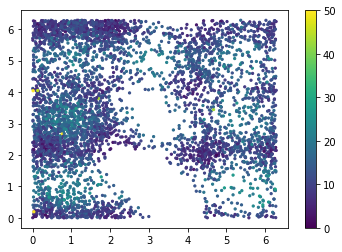

In [130]:
plt.scatter(dihedrals[:, 0], dihedrals[:, 1], c=energy, vmax=50, s=5)
plt.colorbar()

In [131]:
dihedrals.shape

(5000, 2)

In [132]:
ebc = EBC(temperature=TEMPERATURE, proto_radius=0.1, n_clusters=9, boxsize=2 * np.pi, knn=20)
ebc.fit(dihedrals, energy)

Using 1320 proto clusters.


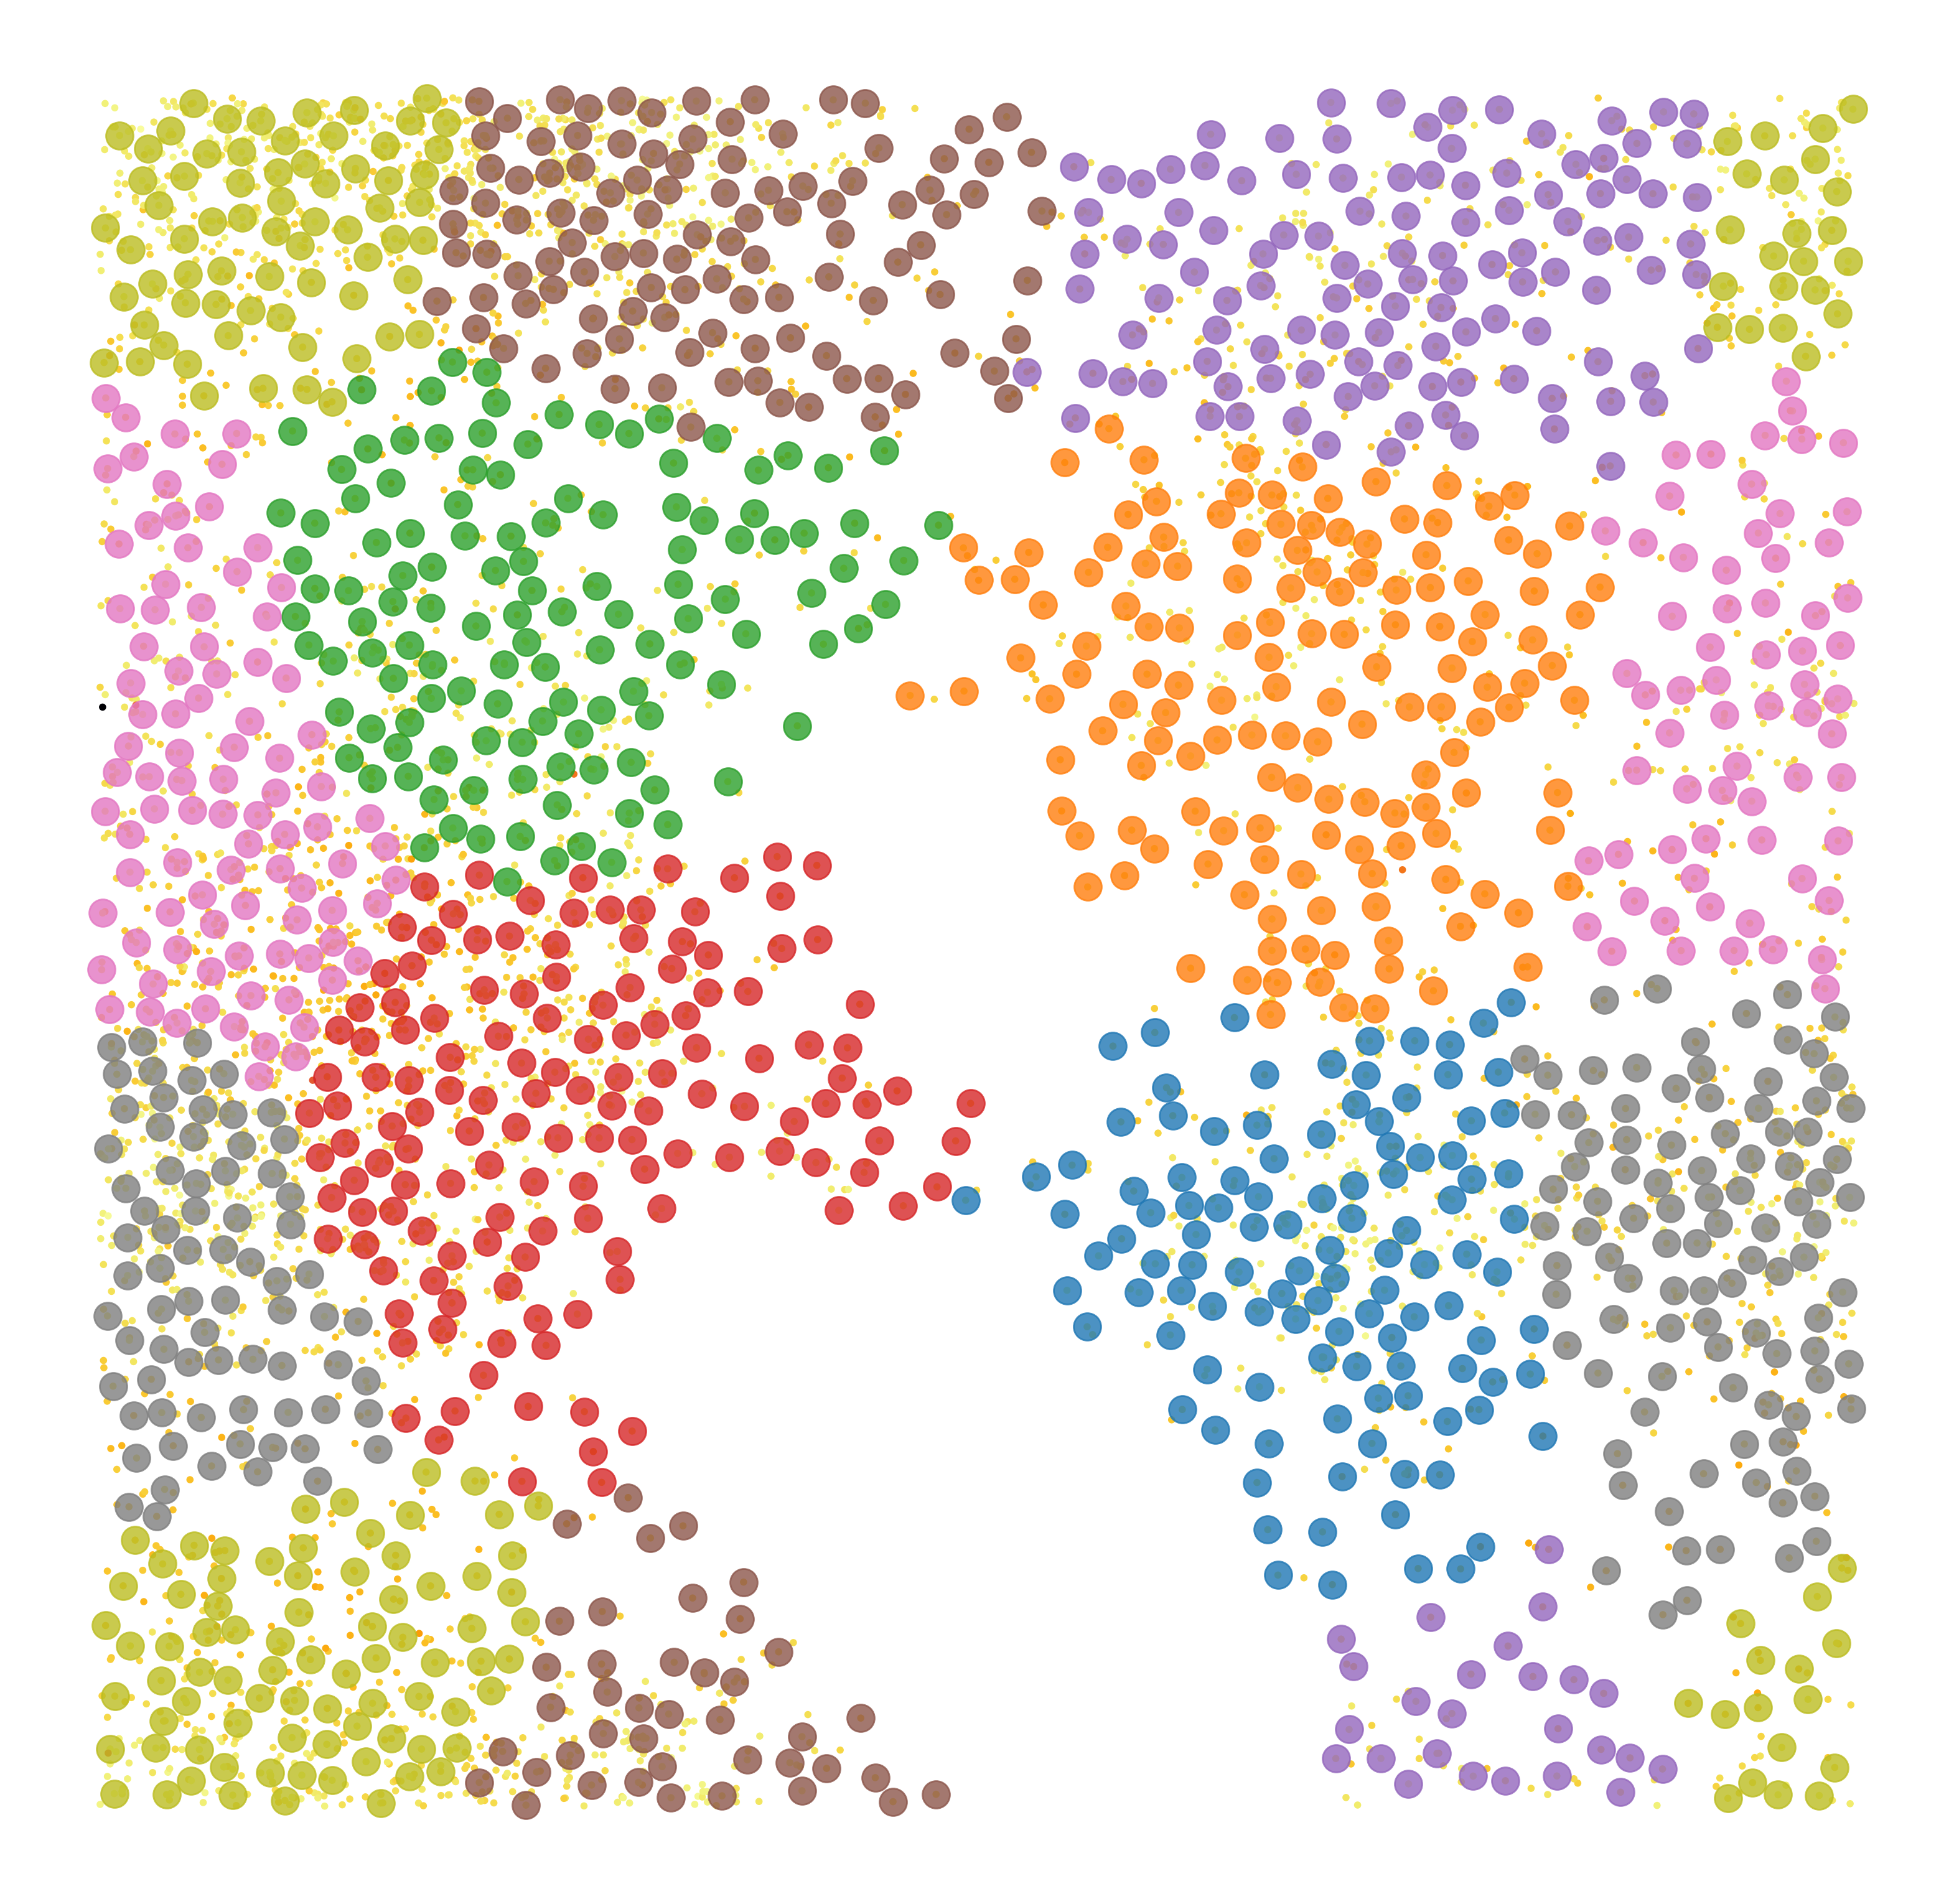

In [133]:
ebc.show()

In [15]:
topology.to_openmm().n_angles

AttributeError: 'Topology' object has no attribute 'n_angles'

In [13]:
dir(topology)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_atoms',
 '_bonds',
 '_chains',
 '_numAtoms',
 '_numResidues',
 '_residues',
 '_standardBonds',
 '_string_summary_basic',
 '_unique_pairs',
 '_unique_pairs_equal',
 '_unique_pairs_mutually_exclusive',
 'add_atom',
 'add_bond',
 'add_chain',
 'add_residue',
 'atom',
 'atoms',
 'atoms_by_name',
 'bonds',
 'chain',
 'chains',
 'copy',
 'create_disulfide_bonds',
 'create_standard_bonds',
 'delete_atom_by_index',
 'find_molecules',
 'from_dataframe',
 'from_openmm',
 'guess_anchor_molecules',
 'insert_atom',
 'join',
 'n_atoms',
 'n_bonds',
 'n_chains',
 'n_residues',
 'residue',
 'residues',
 's